# Datasets
- [pageb_benchmarks.zip](https://ir.library.oregonstate.edu/concern/parent/47429f155/file_sets/1g05fh87w)


# 要求
使用[Python Outlier Detection (PyOD)](https://github.com/yzhao062/pyod)或其他已知的工具包来完成分析工作

# 提交的内容
- 完整的分析代码
- 分析报告：展示分析的思路，详细过程，结果及你的分析
- 所选择的数据集在README中说明，数据文件不要上传到Github中


In [1]:
import pandas as pd
import os
import time
import warnings
import numpy as np

warnings.filterwarnings('ignore')

# timekeeping
timekeeping = time.time()

In [2]:
PAGEB_ROOT = 'pageb/benchmarks'
benchmark_list = os.listdir(PAGEB_ROOT)
print(len(benchmark_list))

940


## 数据来源说明

根据论文[1]可知，数据集中会引入4种不同的层次的不相关特征（i.e., noise）。

要创建新的不相关特征，首先从原始母集中随机选择一个特征。 然后，对于原始数据集中的每个数据点，通过从原始数据点的值进行统一采样（替换）来为此特征选择一个值。 结果是新添加的特征与某些原始特征具有相同的边缘分布，但是其值不包含有关数据点异常状态的信息。这保留了真实数据的特质，同时允许引入噪声。

为了简化确定需要多少不相关特征的过程，如果数据集已经具有$d$维特征，而我们想评估$d^{'}$维，即将成对平均距离增加一个因子$\alpha$所需的维数，那么
\begin{equation}
d^{'} = \left( \alpha \sqrt{d}\right)^2 ~ ~ ~ ~(1)\,,
\end{equation}

其中$\alpha \in \{1.0, 1.2, 1.5, 2.0\}$.

[1] Emmott A, Das S, Dietterich T G, et al. A Meta-Analysis of the Anomaly Detection Problem[J]. arXiv: Artificial Intelligence, 2015.

随机选取一个csv文件，确定该数据集的原始特征有哪些？

In [3]:
df = pd.read_csv(os.path.join(PAGEB_ROOT, benchmark_list[0]))
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4654 entries, 0 to 4653
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   point.id        4654 non-null   object 
 1   motherset       4654 non-null   object 
 2   origin          4654 non-null   object 
 3   original.label  4654 non-null   int64  
 4   diff.score      4654 non-null   float64
 5   ground.truth    4654 non-null   object 
 6   V               4654 non-null   float64
 7   V.1             4654 non-null   float64
 8   V.2             4654 non-null   float64
 9   V.3             4654 non-null   float64
 10  V.4             4654 non-null   float64
 11  V.5             4654 non-null   float64
 12  V.6             4654 non-null   float64
 13  V.7             4654 non-null   float64
 14  V.8             4654 non-null   float64
 15  V.9             4654 non-null   float64
dtypes: float64(11), int64(1), object(4)
memory usage: 581.9+ KB


,point.id,motherset,origin,original.label,diff.score,ground.truth,V,V.1,V.2,V.3,V.4,V.5,V.6,V.7,V.8,V.9
0,pageb_point_2156,pageb,multiclass,1,0.050799,nominal,-0.077700,-0.031103,-0.087518,-0.136725,-0.886844,-1.570670,-0.071357,-0.159746,-0.181295,0.115578
1,pageb_point_4574,pageb,multiclass,3,0.012214,anomaly,3.244986,0.056064,1.178212,-0.404543,0.671466,-1.189799,0.137100,2.367937,1.745354,0.647530
2,pageb_point_1655,pageb,multiclass,1,0.013439,nominal,-0.183182,-0.667426,-0.228360,-0.387477,-0.588683,-0.803068,-0.069620,-0.269166,-0.362533,-0.535914
3,pageb_point_0667,pageb,multiclass,5,0.011605,anomaly,2.190165,3.237675,4.696190,-0.159231,-0.993731,-3.146892,0.076734,3.338549,2.762094,1.753272
4,pageb_point_2081,pageb,multiclass,1,0.054793,nominal,-0.183182,1.023622,0.051676,0.515150,-0.673068,-0.082342,-0.071357,-0.003881,0.199783,1.030057


根据以上的信息我们可以确定，pageb这个数据集的原始特征维度$d=10$(``V``, ``V.1``~``V.9``)。因此，由等式（1）可知，所有csv文件所包含的列数可能为$16=\left(1.0 \times \sqrt{10}\right)^2+6$, $20=\left(1.2 \times \sqrt{10}\right)^2+6$, $28=\left(1.5 \times \sqrt{10}\right)^2+6$, $46=\left(2.0 \times \sqrt{10}\right)^2+6$.

下面我们遍历所有csv文件，验证一下。

In [4]:
d_set = set()
d_count = 0
for i in range(len(benchmark_list)):
    df = pd.read_csv(os.path.join(PAGEB_ROOT, benchmark_list[i]))
    d_set.add(len(df.columns))
    d_count += len(df)
print('Possible columns of all csv files:', d_set)
print('Total amount:', d_count)

Possible columns of all csv files: {16, 20, 28, 46}
Total amount: 3180315


## 实验思路一
将所有的csv文件共同的特征合并，并将合并的数据分成训练集和测试集

### 数据特征提取
为了充分利用所提供的数据集完成离群点分析与异常检测，将提取所有csv文件共同的特征（即原始特征,``V``, ``V.1``~``V.9``）作为算法或模型的输入，用于检测该条数据是否属于异常点。

In [5]:
ORIGIN_FEATURES = ['V', 'V.1', 'V.2', 'V.3', 'V.4', 'V.5', 'V.6', 'V.7', 'V.8', 'V.9', 'ground.truth']
def feature_section(benchmark_list):
    concat_data = pd.DataFrame()
    for i in benchmark_list:
        df = pd.read_csv(os.path.join(PAGEB_ROOT, i))
        concat_data = concat_data.append(df[ORIGIN_FEATURES])
    return concat_data

In [6]:
concat_data = feature_section(benchmark_list=benchmark_list)
concat_data.info()
concat_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3180315 entries, 0 to 4465
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   V             float64
 1   V.1           float64
 2   V.2           float64
 3   V.3           float64
 4   V.4           float64
 5   V.5           float64
 6   V.6           float64
 7   V.7           float64
 8   V.8           float64
 9   V.9           float64
 10  ground.truth  object 
dtypes: float64(10), object(1)
memory usage: 291.2+ MB


,V,V.1,V.2,V.3,V.4,V.5,V.6,V.7,V.8,V.9,ground.truth
0,-0.077700,-0.031103,-0.087518,-0.136725,-0.886844,-1.570670,-0.071357,-0.159746,-0.181295,0.115578,nominal
1,3.244986,0.056064,1.178212,-0.404543,0.671466,-1.189799,0.137100,2.367937,1.745354,0.647530,anomaly
2,-0.183182,-0.667426,-0.228360,-0.387477,-0.588683,-0.803068,-0.069620,-0.269166,-0.362533,-0.535914,nominal
3,2.190165,3.237675,4.696190,-0.159231,-0.993731,-3.146892,0.076734,3.338549,2.762094,1.753272,anomaly
4,-0.183182,1.023622,0.051676,0.515150,-0.673068,-0.082342,-0.071357,-0.003881,0.199783,1.030057,nominal


### 数据集划分
train set : test set = 8 : 2 

In [7]:
def data_label_split(data, label_column='ground.truth'):
    x = data.drop(label_column, axis=1)
    y = []
    for i in data[label_column].values:
        if i == 'nominal':
            y.append(0)
        else:
            y.append(1)
    y = np.array(y)
    return x, y

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(concat_data, test_size=0.2, random_state=2020)

X_train, y_train = data_label_split(train)
X_test, y_test = data_label_split(test)

In [9]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y_train)

'binary'

### 模型比较
#### 单一模型
- KNN
- PCA
- LOF

#### 组合模型
- **Average**: average scores of all detectors
- **Maximization**: maximum score across all detectors.
- **Average of Maximum (AOM)**
- **Maximum of Average (MOA)**

ref: https://github.com/yzhao062/pyod/tree/master/examples

#### kNN
初始化一个 ``pyod.models.knn.KNN`` 检测器, 模型拟合, 然后给出预测。

In [10]:
# train the KNN detector
from pyod.models.knn import KNN

clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

利用 ``ROC`` 和 ``Precision @ Rank`` 评估预测。

In [11]:
from pyod.utils.data import evaluate_print
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
KNN ROC:0.5, precision @ rank n:0.0

On Test Data:
KNN ROC:0.5, precision @ rank n:0.0


#### PCA
初始化一个 ``pyod.models.pca.PCA`` 检测器, 模型拟合, 然后给出预测。

In [12]:
# train PCA detector
from pyod.models.pca import PCA

clf_name = 'PCA'
clf = PCA(n_components=3)
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

利用 ``ROC`` 和 ``Precision @ Rank`` 评估预测

In [13]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
PCA ROC:0.8928, precision @ rank n:0.2423

On Test Data:
PCA ROC:0.8925, precision @ rank n:0.2426


#### LOF
初始化一个 ``pyod.models.lof.LOF`` 检测器, 模型拟合, 然后给出预测。

In [14]:
# train LOF detector
from pyod.models.lof import LOF
clf_name = 'LOF'
clf = LOF()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

利用 ``ROC`` 和 ``Precision @ Rank`` 评估预测

In [15]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
LOF ROC:0.5, precision @ rank n:0.0

On Test Data:
LOF ROC:0.5, precision @ rank n:0.0


#### 组合模型
用不同的k(10 ～ 200)初始化20个 ``kNN`` 离群点检测器，然后得到所有的离群点的分数。

In [16]:
from pyod.models.knn import KNN  # kNN detector
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer

In [17]:
# standardizing data for processing
X_train_norm, X_test_norm = standardizer(X_train, X_test)

n_clf = 20  # number of base detectors

# initialize 20 base detectors for combination
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

print('Combining {n_clf} kNN detectors'.format(n_clf=n_clf))

for i in range(n_clf):
    k = k_list[i]

    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(X_train_norm)

    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(X_test_norm)

Combining 20 kNN detectors


In [18]:
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)

# Combination by average
y_by_average = average(test_scores_norm)
# Combination by max
y_by_maximization = maximization(test_scores_norm)
# Combination by aom
y_by_aom = aom(test_scores_norm, n_buckets=5)
# Combination by moa
y_by_moa = moa(test_scores_norm, n_buckets=5)

In [19]:
print("\nOn Test Data:")
evaluate_print('Combination by Average', y_test, y_by_average)
evaluate_print('Combination by Maximization', y_test, y_by_maximization)
evaluate_print('Combination by AOM', y_test, y_by_aom)
evaluate_print('Combination by MOA', y_test, y_by_moa)


On Test Data:
Combination by Average ROC:0.6484, precision @ rank n:1.0
Combination by Maximization ROC:0.6484, precision @ rank n:1.0
Combination by AOM ROC:0.6484, precision @ rank n:1.0
Combination by MOA ROC:0.6484, precision @ rank n:1.0


## 实验思路二
对每个csv文件分开处理，因为有的数据集样本个数较少，所以就以无监督的形式训练整个csv样本，并在对整个训练数据进行测试，检测该条数据是否属于异常点。

In [20]:
# evaluate using ROC and precision @ rank n

from sklearn.utils import column_or_1d
from sklearn.utils import check_consistent_length
from sklearn.metrics import roc_auc_score

from pyod.utils.utility import precision_n_scores
import numpy as np

def evaluate(y, y_pred):
    y = column_or_1d(y)
    y_pred = column_or_1d(y_pred)
    check_consistent_length(y, y_pred)

#     print('ROC:{roc}, precision @ rank n:{prn}'.format(
#         roc=np.round(roc_auc_score(y, y_pred), decimals=4),
#         prn=np.round(precision_n_scores(y, y_pred), decimals=4)))
    
    return np.round(roc_auc_score(y, y_pred), decimals=4), np.round(precision_n_scores(y, y_pred), decimals=4)

In [21]:
# tSNE dimension reduction for visualization

from sklearn.manifold import TSNE

def tsne(original_data):
    # T-SNE Implementation
    t0 = time.time()
    reduced_tsne = TSNE(n_components=2, random_state=2020, init='pca').fit_transform(original_data.values)
    t1 = time.time()
    print("T-SNE took {:.2} s".format(t1 - t0))
    return reduced_tsne

In [22]:
# fit model in unsupervised manner and predict 

def model_evaluation(clf, data):
    
    X_train, y_train = data_label_split(data)
    
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores
    
    
    roc, prn = evaluate(y_train, y_train_scores)
    
    
    return y_train_pred, roc, prn

In [23]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def visualization(data, y_pred):
    
    X_train, y_train = data_label_split(data)
    X_reduced_tsne = tsne(X_train)
    
    f, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,6))


    blue_patch = mpatches.Patch(color='#0A0AFF', label='nominal')
    red_patch = mpatches.Patch(color='#AF0000', label='anomaly')
    
     # true visualization
    ax0.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_train == 0), cmap='coolwarm', label='nominal', linewidths=2)
    ax0.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_train == 1), cmap='coolwarm', label='anomaly', linewidths=2)
    ax0.set_title('ground-truth t-SNE visualization', fontsize=14)

    ax0.legend(handles=[blue_patch, red_patch])
    ax0.set_xticks([])
    ax0.set_yticks([])

    # predicted visualization
    ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_pred == 0), cmap='coolwarm', label='nominal', linewidths=2)
    ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_pred == 1), cmap='coolwarm', label='anomaly', linewidths=2)
    ax1.set_title('prediction t-SNE visualization', fontsize=14)

    ax1.legend(handles=[blue_patch, red_patch])
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    plt.show()

99 pageb_benchmark_1314.csv
best model: PCA ROC: 0.8033 precision @ rank n: 0.1202
T-SNE took 1.6e+01 s


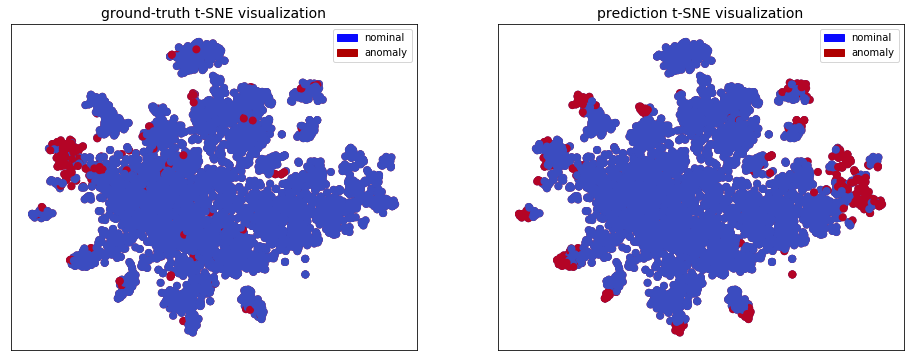

199 pageb_benchmark_0996.csv
best model: PCA ROC: 0.791 precision @ rank n: 0.0667
T-SNE took 1.5e+01 s


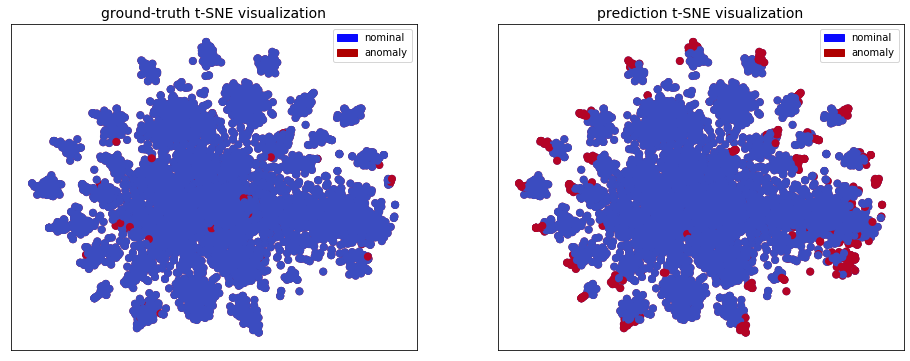

299 pageb_benchmark_1503.csv
best model: PCA ROC: 0.8969 precision @ rank n: 0.4756
T-SNE took 1.1e+01 s


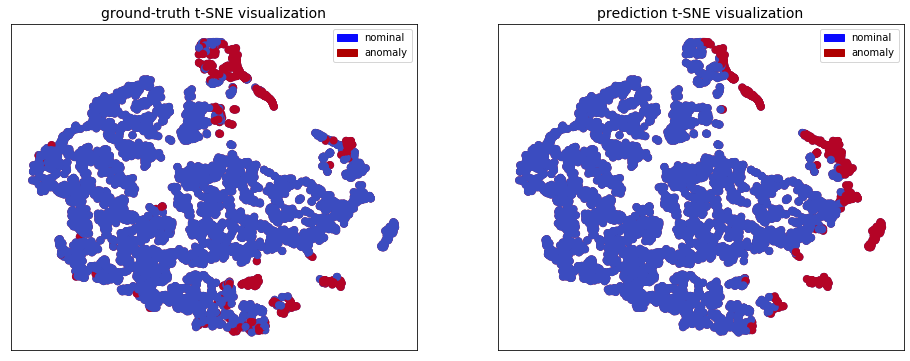

399 pageb_benchmark_0295.csv
best model: PCA ROC: 0.5769 precision @ rank n: 0.5429
T-SNE took 0.73 s


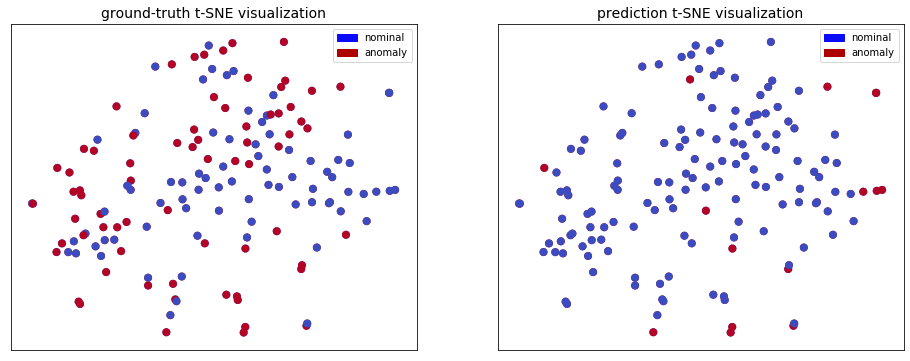

499 pageb_benchmark_0659.csv
best model: PCA ROC: 0.9637 precision @ rank n: 0.0
T-SNE took 9.6 s


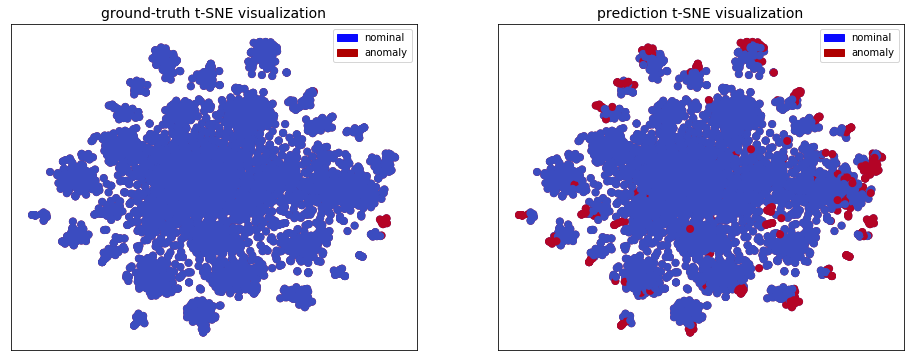

599 pageb_benchmark_0014.csv
best model: PCA ROC: 0.8092 precision @ rank n: 0.3326
T-SNE took 1.2e+01 s


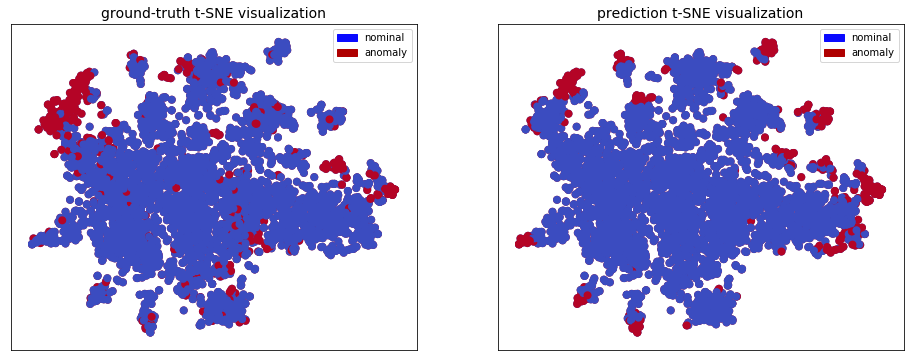

699 pageb_benchmark_0703.csv
best model: PCA ROC: 0.9321 precision @ rank n: 0.0435
T-SNE took 9.1 s


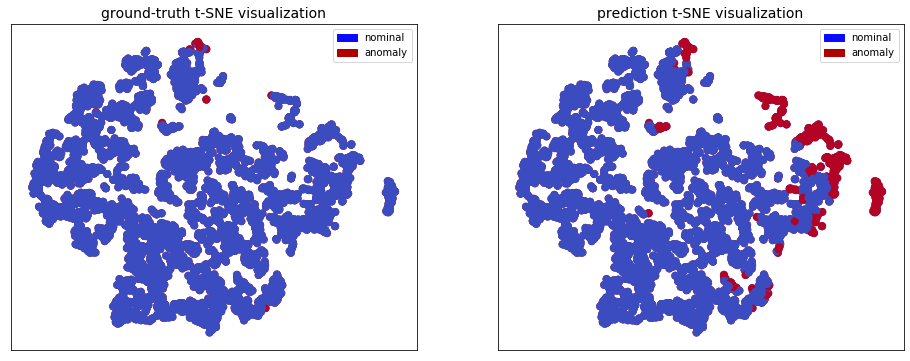

799 pageb_benchmark_0099.csv
best model: PCA ROC: 0.7214 precision @ rank n: 0.252
T-SNE took 1.6e+01 s


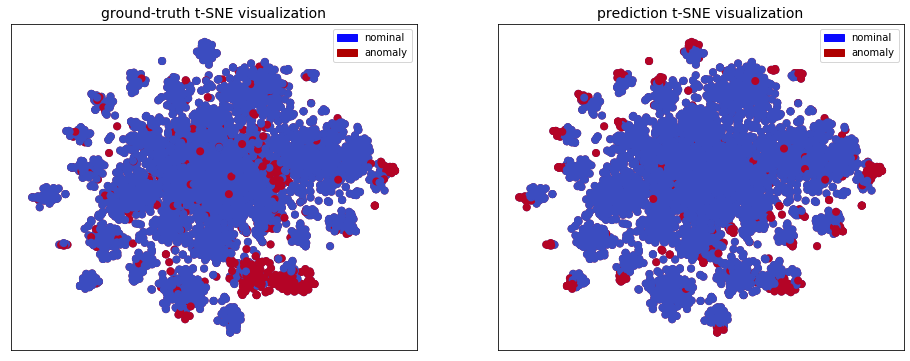

899 pageb_benchmark_0312.csv
best model: PCA ROC: 0.8454 precision @ rank n: 0.0
T-SNE took 1.2e+01 s


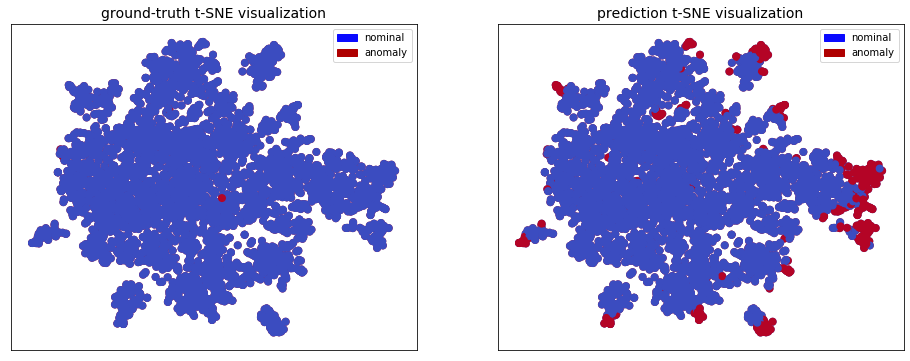

+--------------------------+-------+--------+--------------------+
|         csv_file         | model |  ROC   | precision @ rank n |
+--------------------------+-------+--------+--------------------+
| pageb_benchmark_1224.csv |  KNN  | 0.8336 |       0.4592       |
| pageb_benchmark_1224.csv |  PCA  | 0.9209 |       0.3519       |
| pageb_benchmark_1224.csv |  LOF  | 0.781  |       0.3691       |
| pageb_benchmark_0945.csv |  KNN  | 0.7816 |       0.1333       |
| pageb_benchmark_0945.csv |  PCA  | 0.922  |       0.0444       |
| pageb_benchmark_0945.csv |  LOF  | 0.6723 |        0.2         |
| pageb_benchmark_0307.csv |  KNN  | 0.7967 |        0.0         |
| pageb_benchmark_0307.csv |  PCA  | 0.8573 |        0.0         |
| pageb_benchmark_0307.csv |  LOF  | 0.8548 |        0.2         |
| pageb_benchmark_0086.csv |  KNN  | 0.8181 |       0.4048       |
| pageb_benchmark_0086.csv |  PCA  | 0.8583 |       0.3698       |
| pageb_benchmark_0086.csv |  LOF  | 0.7419 |       0.372     

In [25]:
from pyod.models.knn import KNN
from pyod.models.pca import PCA
from pyod.models.lof import LOF
import prettytable as pt

# Add or replace models
model_list = {'KNN': KNN(), 'PCA': PCA(), 'LOF': LOF()}

tb = pt.PrettyTable( ['csv_file', 'model', 'ROC', 'precision @ rank n'])
for i in range(len(benchmark_list)):
    
    df = pd.read_csv(os.path.join(PAGEB_ROOT, benchmark_list[i]))
    
    df = df.drop(['point.id', 'motherset', 'origin', 'original.label', 'diff.score'], axis=1)

    best_roc = 0
    best_model = None
    best_pred = None
    best_prn = None
    for model in model_list:
        y_train_pred, roc, prn = model_evaluation(model_list[model], df)
        tb.add_row([benchmark_list[i], model, roc, prn])
        if roc >= best_roc:
            best_roc = roc
            best_pred = y_train_pred
            best_model = model
            best_prn = prn
    
    if (i + 1) % 100 == 0:
        # visualize once / 100 files
        print(i, benchmark_list[i])
        print('best model:', best_model, 'ROC:', best_roc, 'precision @ rank n:', best_prn)
        visualization(df, best_pred)

print(tb)

In [26]:
m, s = divmod(time.time()-timekeeping, 60)
h, m = divmod(m, 60)
print ('run time: %02d:%02d:%02d' % (h, m, s))

run time: 03:19:58
